In [1]:
import pandas as pd
import os

# The file is correctly located inside the 'data' folder
DATA_FILE = "data/MachineLearningRating_v3.txt" 

print(f"Attempting to load data from: {DATA_FILE} using Pipe separator (sep='|')")
try:
    df = pd.read_csv(DATA_FILE, sep='|', skipinitialspace=True) 
    
    print("\n--- Data reloaded successfully! ---")
    
    # CRITICAL PRE-STEP: Aggressive Column Name Cleaning
    # Remove all characters that are not a-z, A-Z, 0-9, or underscore, and strip whitespace.
    df.columns = df.columns.str.replace(r'[^A-Za-z0-9_]+', '', regex=True).str.strip()
    
    print("All column names have been aggressively cleaned.")
    
except Exception as e:
    print(f"\nFailed to reload data. Error: {e}")

Attempting to load data from: data/MachineLearningRating_v3.txt using Pipe separator (sep='|')


C:\Users\Mer\AppData\Local\Temp\ipykernel_8956\655185960.py:9: DtypeWarning: Columns (4,32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_FILE, sep='|', skipinitialspace=True)



--- Data reloaded successfully! ---
All column names have been aggressively cleaned.


In [2]:
# 1. Drop high-missing columns (the column names are now clean)
# We use the cleaned names (e.g., 'NumberOfVehiclesInFleet' will be used assuming the cleaning worked)
cols_to_drop = ['NumberOfVehiclesInFleet', 'CrossBorder', 'CustomValueEstimate']
df = df.drop(columns=cols_to_drop)
print(f"Dropped high-missing columns: {cols_to_drop}")

# 2. Fix Boolean/Flag Columns (WrittenOff, Rebuilt, Converted)
# NOTE: NewVehicle is correctly treated as categorical.
flag_cols = ['WrittenOff', 'Rebuilt', 'Converted']
for col in flag_cols:
    df[col] = df[col].replace({' ': pd.NA, '': pd.NA}) 
    df[col] = df[col].replace({'Yes': 1, 'No': 0})
    df[col] = df[col].fillna(0).astype(int)
    
print(f"Cleaned and converted flag columns to binary (0/1): {flag_cols}")


# 3. Handle 'CapitalOutstanding' (Monetary Column)
df['CapitalOutstanding'] = pd.to_numeric(df['CapitalOutstanding'], errors='coerce').fillna(0)
print("CapitalOutstanding converted to numeric and filled NaNs with 0.")


# 4. Handle Categorical Columns with low-to-moderate missingness
# Impute with a new category 'Unknown'. Includes 'NewVehicle' now.
categorical_cols_to_impute = ['Bank', 'AccountType', 'MaritalStatus', 'Gender', 
                              'Citizenship', 'LegalType', 'NewVehicle']
for col in categorical_cols_to_impute:
    df[col] = df[col].replace(' ', pd.NA).fillna('Unknown')
print(f"Categorical columns filled with 'Unknown', including NewVehicle.")


# 5. Drop Rows with Negligible Missing Data (Vehicle Characteristics)
# We drop the 552 rows where key vehicle data is missing.
df = df.dropna(subset=['mmcode', 'VehicleType', 'make', 'Model', 'Cylinders', 
                       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate'])

# 6. Final Data Type Fix
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])


# Final check of the data frame structure
print(f"\nRemaining rows after dropping rows with missing vehicle data: {len(df)}")
print("\n--- Final Data Structure Check (df.info()) ---")
df.info(verbose=False)

Dropped high-missing columns: ['NumberOfVehiclesInFleet', 'CrossBorder', 'CustomValueEstimate']


C:\Users\Mer\AppData\Local\Temp\ipykernel_8956\922420419.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0})
C:\Users\Mer\AppData\Local\Temp\ipykernel_8956\922420419.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0})
C:\Users\Mer\AppData\Local\Temp\ipykernel_8956\922420419.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.in

Cleaned and converted flag columns to binary (0/1): ['WrittenOff', 'Rebuilt', 'Converted']
CapitalOutstanding converted to numeric and filled NaNs with 0.
Categorical columns filled with 'Unknown', including NewVehicle.

Remaining rows after dropping rows with missing vehicle data: 999546

--- Final Data Structure Check (df.info()) ---
<class 'pandas.core.frame.DataFrame'>
Index: 999546 entries, 0 to 1000097
Columns: 49 entries, UnderwrittenCoverID to TotalClaims
dtypes: bool(1), datetime64[ns](1), float64(10), int64(7), object(30)
memory usage: 374.6+ MB


In [3]:
# --- Statistical Summary (Mean, Median, Std Dev) ---

# Focus on the target (TotalClaims) and main features (TotalPremium, SumInsured)
key_stats = df[['TotalClaims', 'TotalPremium', 'SumInsured', 'CalculatedPremiumPerTerm']].describe().T
key_stats['median'] = df[['TotalClaims', 'TotalPremium', 'SumInsured', 'CalculatedPremiumPerTerm']].median()

print("\n--- Key Descriptive Statistics ---")
print(key_stats[['count', 'mean', 'median', 'std', 'min', 'max']].round(2))


--- Key Descriptive Statistics ---
                             count       mean   median         std       min  \
TotalClaims               999546.0      64.34     0.00     2369.56 -12002.41   
TotalPremium              999546.0      61.37     2.18      157.01   -782.58   
SumInsured                999546.0  603869.28  7500.00  1507340.00      0.01   
CalculatedPremiumPerTerm  999546.0     116.16     8.44      220.58      0.00   

                                  max  
TotalClaims                 393092.11  
TotalPremium                  2253.51  
SumInsured                10000000.00  
CalculatedPremiumPerTerm      3051.82  


In [4]:
# --- Outlier and Data Quality Cleaning ---

# 1. Handle Negative Values (Critical Fix)
# Set all negative claims and premiums to zero.
df['TotalClaims'] = df['TotalClaims'].apply(lambda x: max(0, x))
df['TotalPremium'] = df['TotalPremium'].apply(lambda x: max(0, x))
df['CalculatedPremiumPerTerm'] = df['CalculatedPremiumPerTerm'].apply(lambda x: max(0, x))

print("Negative values in Claims and Premiums have been fixed to 0.")


# 2. Re-check Descriptive Statistics after fix
print("\n--- Descriptive Statistics AFTER Cleaning ---")
cleaned_stats = df[['TotalClaims', 'TotalPremium', 'SumInsured', 'CalculatedPremiumPerTerm']].describe().T
cleaned_stats['median'] = df[['TotalClaims', 'TotalPremium', 'SumInsured', 'CalculatedPremiumPerTerm']].median()
print(cleaned_stats[['count', 'mean', 'median', 'std', 'min', 'max']].round(2))

Negative values in Claims and Premiums have been fixed to 0.

--- Descriptive Statistics AFTER Cleaning ---
                             count       mean   median         std   min  \
TotalClaims               999546.0      64.36     0.00     2369.53  0.00   
TotalPremium              999546.0      61.40     2.18      156.96  0.00   
SumInsured                999546.0  603869.28  7500.00  1507340.00  0.01   
CalculatedPremiumPerTerm  999546.0     116.16     8.44      220.58  0.00   

                                  max  
TotalClaims                 393092.11  
TotalPremium                  2253.51  
SumInsured                10000000.00  
CalculatedPremiumPerTerm      3051.82  


In [5]:
# --- Temporal Analysis: Claims Trend ---

# Set 'TransactionMonth' as the index for time series analysis
df_time = df.set_index('TransactionMonth')

# Calculate the mean TotalClaims per month
monthly_claims_mean = df_time['TotalClaims'].resample('M').mean()

# Calculate the total number of policies (rows) per month
monthly_policies_count = df_time['PolicyID'].resample('M').count()

print("\n--- Monthly Average Claims (Mean Claims per Policy) ---")
print(monthly_claims_mean)

print("\n--- Monthly Policy Count (Volume Trend) ---")
print(monthly_policies_count)

C:\Users\Mer\AppData\Local\Temp\ipykernel_8956\3404425179.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_claims_mean = df_time['TotalClaims'].resample('M').mean()
C:\Users\Mer\AppData\Local\Temp\ipykernel_8956\3404425179.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_policies_count = df_time['PolicyID'].resample('M').count()



--- Monthly Average Claims (Mean Claims per Policy) ---
TransactionMonth
2013-10-31     0.000000
2013-11-30    42.295217
2013-12-31     6.209623
2014-01-31     6.807258
2014-02-28    30.547676
2014-03-31    93.128973
2014-04-30    44.350859
2014-05-31    54.657432
2014-06-30    42.677753
2014-07-31    28.819863
2014-08-31    35.943245
2014-09-30    35.201030
2014-10-31    52.191326
2014-11-30    76.712045
2014-12-31    97.270323
2015-01-31    76.778534
2015-02-28    73.351793
2015-03-31    81.279501
2015-04-30    92.796797
2015-05-31    69.745481
2015-06-30    60.509710
2015-07-31    64.860019
2015-08-31     9.558443
Freq: ME, Name: TotalClaims, dtype: float64

--- Monthly Policy Count (Volume Trend) ---
TransactionMonth
2013-10-31        45
2013-11-30      1196
2013-12-31      1495
2014-01-31      1827
2014-02-28      2062
2014-03-31      3466
2014-04-30      6919
2014-05-31      9484
2014-06-30     11822
2014-07-31     14907
2014-08-31     19626
2014-09-30     25982
2014-10-31     3

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Set a style for professional visualization
sns.set_style("whitegrid")

# --- 1. Distribution of TotalClaims (Log-Transformed) ---
# Filter non-zero claims for the log transform visualization
df_non_zero_claims = df[df['TotalClaims'] > 0]['TotalClaims']

plt.figure(figsize=(10, 5))
# Use log(1 + x) to handle the extreme skewness and visualize the distribution shape better
sns.histplot(np.log1p(df_non_zero_claims), bins=50, kde=True, color='skyblue')
plt.title('Distribution of Total Claims (Log-Transformed, Claims > 0)')
plt.xlabel('Log(1 + Total Claims)')
plt.ylabel('Frequency')
plt.savefig('claims_distribution.png')
plt.close()
print("Saved claims_distribution.png")


# --- 2. Temporal Trend of Claims ---
# Recalculate monthly mean claims using 'ME' (Month End) standard
df_time = df.set_index('TransactionMonth')
monthly_claims_mean = df_time['TotalClaims'].resample('ME').mean()

plt.figure(figsize=(12, 6))
monthly_claims_mean.plot(kind='line', marker='o', linestyle='-', color='teal')
plt.title('Monthly Average Total Claims Over Time (Risk Profile)')
plt.xlabel('Transaction Month')
plt.ylabel('Average Claims per Policy')
plt.grid(True)
plt.tight_layout()
plt.savefig('claims_temporal_trend.png')
plt.close()
print("Saved claims_temporal_trend.png")


# --- 3. Categorical Risk Factor: Mean Claims by Province ---
# Calculate the mean TotalClaims per Province and take the top 10
province_claims = df.groupby('Province')['TotalClaims'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=province_claims.index, y=province_claims.values, palette='viridis')
plt.title('Top 10 Provinces by Average Total Claims')
plt.xlabel('Province')
plt.ylabel('Average Total Claims (USD)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('claims_by_province.png')
plt.close()
print("Saved claims_by_province.png")

Saved claims_distribution.png
Saved claims_temporal_trend.png


C:\Users\Mer\AppData\Local\Temp\ipykernel_8956\3567743579.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=province_claims.index, y=province_claims.values, palette='viridis')


Saved claims_by_province.png


In [7]:
# --- BIVARIATE ANALYSIS: LOSS RATIO ---

# 1. Calculate overall Loss Ratio
total_claims_sum = df['TotalClaims'].sum()
total_premium_sum = df['TotalPremium'].sum()

# Add a small epsilon to the denominator to prevent division by zero
epsilon = 1e-6
overall_loss_ratio = (total_claims_sum / (total_premium_sum + epsilon)) * 100
print(f"Overall Portfolio Loss Ratio: {overall_loss_ratio:.2f}%")

print("\n--- Loss Ratio by Key Risk Factors ---")

# 2. Calculate Loss Ratio by Categorical Variables
risk_factors = ['Province', 'VehicleType', 'Gender']

for factor in risk_factors:
    # Group by the factor and sum Claims and Premiums
    df_grouped = df.groupby(factor).agg(
        TotalClaims=('TotalClaims', 'sum'),
        TotalPremium=('TotalPremium', 'sum')
    )
    
    # Calculate Loss Ratio for the group
    df_grouped['LossRatio'] = (df_grouped['TotalClaims'] / (df_grouped['TotalPremium'] + epsilon)) * 100
    
    # Filter out categories with very low exposure (e.g., total premium < 1000)
    df_grouped = df_grouped[df_grouped['TotalPremium'] > 1000].sort_values(by='LossRatio', ascending=False)
    
    print(f"\n{factor} Loss Ratio (Top 5):\n", df_grouped[['LossRatio']].head(5).round(2))

# --- BIVARIATE ANALYSIS: Correlation between TotalPremium and TotalClaims ---
# Although highly skewed, a basic correlation check is part of the requirement.
premium_claims_corr = df[['TotalPremium', 'TotalClaims']].corr().loc['TotalPremium', 'TotalClaims']
print(f"\nCorrelation between TotalPremium and TotalClaims: {premium_claims_corr:.4f}")

Overall Portfolio Loss Ratio: 104.81%

--- Loss Ratio by Key Risk Factors ---

Province Loss Ratio (Top 5):
                LossRatio
Province                
Gauteng           122.27
KwaZulu-Natal     108.05
Western Cape      106.39
North West         79.04
Mpumalanga         72.12

VehicleType Loss Ratio (Top 5):
                    LossRatio
VehicleType                 
Heavy Commercial      162.81
Medium Commercial     105.02
Passenger Vehicle     104.79
Light Commercial       23.21
Bus                    13.73

Gender Loss Ratio (Top 5):
                LossRatio
Gender                  
Not specified     106.03
Male               86.93
Female             82.19
Unknown            61.45

Correlation between TotalPremium and TotalClaims: 0.0884


In [8]:
# --- BIVARIATE ANALYSIS: Vehicle Make/Model Risk ---

# Group by make and calculate mean claims, taking the top 5 highest risk makes
make_risk = df.groupby('make')['TotalClaims'].mean().sort_values(ascending=False).head(5)

print("\n--- Top 5 Highest-Risk Vehicle Makes (by Avg Claims) ---")
print(make_risk.round(2))


# --- OUTLIER DETECTION: Box Plot ---

# This visualization confirms the extreme outliers we fixed statistically (where median is 0).
# We only plot the top 5% of TotalPremium values to make the box plot visible due to skewness,
# but for a full view, we will use the clean TotalPremium.

plt.figure(figsize=(10, 5))
# Since TotalClaims has so many zeros, we'll plot TotalPremium as it has a clearer continuous distribution.
sns.boxplot(y=df['TotalPremium'])
plt.title('Box Plot of TotalPremium (Outlier Detection)')
plt.ylabel('Total Premium (USD)')
plt.savefig('premium_boxplot.png')
plt.close()
print("Saved premium_boxplot.png to confirm outliers.")


--- Top 5 Highest-Risk Vehicle Makes (by Avg Claims) ---
make
SUZUKI                                 419.63
JMC                                    191.68
HYUNDAI                                174.22
MARCOPOLO                              156.79
AUDI                                   137.84
Name: TotalClaims, dtype: float64
Saved premium_boxplot.png to confirm outliers.


In [9]:
# --- FINAL UNIVARIATE ANALYSIS: Categorical Distributions ---

categorical_cols_for_plot = ['Gender', 'VehicleType']

# Plot the distribution of Gender
plt.figure(figsize=(8, 4))
sns.countplot(y=df['Gender'], order=df['Gender'].value_counts().index, palette='Pastel1')
plt.title('Distribution of Policies by Gender')
plt.xlabel('Count of Policies')
plt.ylabel('Gender')
plt.tight_layout()
plt.savefig('distribution_gender.png')
plt.close()
print("Saved distribution_gender.png")

# Plot the distribution of Vehicle Type
plt.figure(figsize=(10, 5))
sns.countplot(y=df['VehicleType'], order=df['VehicleType'].value_counts().index, palette='Pastel2')
plt.title('Distribution of Policies by Vehicle Type')
plt.xlabel('Count of Policies')
plt.ylabel('Vehicle Type')
plt.tight_layout()
plt.savefig('distribution_vehicle_type.png')
plt.close()
print("Saved distribution_vehicle_type.png")

C:\Users\Mer\AppData\Local\Temp\ipykernel_8956\1765109743.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Gender'], order=df['Gender'].value_counts().index, palette='Pastel1')


Saved distribution_gender.png


C:\Users\Mer\AppData\Local\Temp\ipykernel_8956\1765109743.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['VehicleType'], order=df['VehicleType'].value_counts().index, palette='Pastel2')


Saved distribution_vehicle_type.png


In [11]:
# --- FINAL BIVARIATE/MULTIVARIATE ANALYSIS ---

# 1. Data Comparison: Trends in Insurance Cover Type (Risk Ratio)
# Calculate the Loss Ratio (Claims / Premium) for each CoverType

epsilon = 1e-6
cover_type_risk = df.groupby('CoverType').agg(
    TotalClaims=('TotalClaims', 'sum'),
    TotalPremium=('TotalPremium', 'sum')
)
cover_type_risk['LossRatio'] = (cover_type_risk['TotalClaims'] / (cover_type_risk['TotalPremium'] + epsilon)) * 100

print("\n--- Loss Ratio by Cover Type (Risk Comparison) ---")
# Filter out tiny exposure groups (e.g., less than 500 total premium) and show the comparison
print(cover_type_risk[cover_type_risk['TotalPremium'] > 500].sort_values(by='LossRatio', ascending=False).head(10).round(2))


# 2. Correlations/Associations Proxy: High-Risk Postal Codes (Micro-Geography Risk)
# This identifies the riskiest micro-geographies by average claims, fulfilling the actionable part of the ZipCode requirement.

postal_code_risk = df.groupby('PostalCode').agg(
    MeanClaims=('TotalClaims', 'mean'),
    PolicyCount=('PolicyID', 'count')
).reset_index()

# Filter for Postal Codes with significant exposure (e.g., at least 50 policies)
postal_code_risk = postal_code_risk[postal_code_risk['PolicyCount'] >= 50]
top_10_risky_postal_codes = postal_code_risk.sort_values(by='MeanClaims', ascending=False).head(10)

print("\n--- Top 10 Highest-Risk Postal Codes (Mean Claims, Min 50 Policies) ---")
print(top_10_risky_postal_codes.round(2))


--- Loss Ratio by Cover Type (Risk Comparison) ---
                     TotalClaims  TotalPremium  LossRatio
CoverType                                                
Own Damage           58479523.85   36875771.69     158.59
Windscreen            1280177.06    1288564.35      99.35
Income Protector      2565458.77    2973185.63      86.29
Deposit Cover           43859.65      66835.30      65.62
Credit Protection      332589.38    1846776.47      18.01
Third Party           1578529.61   13370795.89      11.81
Roadside Assistance      3344.10      34485.89       9.70
Emergency Charges       16666.67     320896.51       5.19
Keys and Alarms          8273.33     213931.22       3.87
Accidental Death            0.00     763056.93       0.00

--- Top 10 Highest-Risk Postal Codes (Mean Claims, Min 50 Policies) ---
     PostalCode  MeanClaims  PolicyCount
470        2920     1758.28           55
241        1342     1548.41          110
319        1751     1343.31           77
881        9756

In [13]:
import pandas as pd
import numpy as np

# --- 1. Data Loading (Assuming the clean file structure) ---
# Replace this path with the actual path to your file if you moved it outside of 'data/'
# Note: DVC pull should have restored this file to the 'data/' directory.
file_path = 'data/MachineLearningRating_v3.txt'

# Load the data using the pipe delimiter
df = pd.read_csv(file_path, sep='|')

# --- 2. Essential Cleaning from EDA ---
# Rename columns for ease of use (if you did this in EDA)
df.columns = df.columns.str.replace(' ', '').str.replace('/', '')

# Ensure key variables are numeric and clean non-sensical negatives
financial_cols = ['TotalClaims', 'TotalPremium', 'CustomValueEstimate']
for col in financial_cols:
    # Convert to numeric, coercing errors to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Replace non-sensical negative values with 0 (as done in EDA)
    df.loc[df[col] < 0, col] = 0

# Convert Gender to string and clean up.
df['Gender'] = df['Gender'].astype(str).str.strip()

In [5]:
import numpy as np
from scipy import stats

# --- Prepare the data for the T-test ---
# Filter claims for Male and Female. We use TotalClaims as a proxy for risk severity.
male_claims = df[df['Gender'] == 'Male']['TotalClaims']
female_claims = df[df['Gender'] == 'Female']['TotalClaims']

# Clean the data: Filter out the 'Unknown' and other non-binary values if they were not already cleaned.
# (Assuming they were handled, we just compare Male and Female groups here)

# --- Check for Variance (Levene's Test) ---
# T-tests assume equal variance. Levene's test checks this.
# If p-value < 0.05, variances are unequal (use equal_var=False in t-test)
levene_test = stats.levene(male_claims, female_claims)
print(f"Levene's Test P-value (for variance equality): {levene_test.pvalue:.4f}")

# --- Perform Two-Sample T-Test ---
# We generally assume unequal variances (Welch's T-test) for real-world insurance data.
# The `equal_var=False` parameter implements Welch's T-test, which is robust to unequal variances.
t_stat, p_value = stats.ttest_ind(male_claims, female_claims, equal_var=False)

# Set significance level
alpha = 0.05

print("\n--- Two-Sample T-Test Results (Male vs. Female Claims) ---")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.10f}") # Show more precision for the p-value

# --- Conclusion ---
if p_value < alpha:
    print(f"\nConclusion: Reject the Null Hypothesis. The P-value ({p_value:.10f}) is less than alpha ({alpha}).")
    print("The difference in mean claims between Male and Female policyholders is STATISTICALLY SIGNIFICANT.")
else:
    print(f"\nConclusion: Fail to Reject the Null Hypothesis. The P-value ({p_value:.10f}) is greater than alpha ({alpha}).")
    print("The difference in mean claims is not statistically significant.")

Levene's Test P-value (for variance equality): 0.8041

--- Two-Sample T-Test Results (Male vs. Female Claims) ---
T-statistic: -0.2964
P-value: 0.7669656472

Conclusion: Fail to Reject the Null Hypothesis. The P-value (0.7669656472) is greater than alpha (0.05).
The difference in mean claims is not statistically significant.


In [14]:
# --- 1. Claim Severity: T-Test (Comparing means of non-zero claims) ---

# 1. Create a Claims-Only Dataframe
claims_only_df = df[df['TotalClaims'] > 0].copy()

# 2. Segment the Data
male_severity = claims_only_df[claims_only_df['Gender'] == 'Male']['TotalClaims']
female_severity = claims_only_df[claims_only_df['Gender'] == 'Female']['TotalClaims']

# Ensure groups are large enough
print(f"Severity Sample Size: Male={len(male_severity)}, Female={len(female_severity)}")

# 3. Perform Welch's T-Test (robust for potentially unequal variances)
t_stat_sev, p_value_sev = stats.ttest_ind(male_severity, female_severity, equal_var=False)
alpha = 0.05

print("\n--- T-Test Results: Gender Claim Severity (Claims > 0) ---")
print(f"T-statistic: {t_stat_sev:.4f}")
print(f"P-value: {p_value_sev:.10f}")

# 4. Conclusion
if p_value_sev < alpha:
    print(f"\nConclusion: Reject H₀. The difference in average claim severity is STATISTICALLY SIGNIFICANT.")
else:
    print(f"\nConclusion: Fail to Reject H₀. The difference in average claim severity is NOT statistically significant.")

Severity Sample Size: Male=94, Female=14

--- T-Test Results: Gender Claim Severity (Claims > 0) ---
T-statistic: -0.5790
P-value: 0.5680286952

Conclusion: Fail to Reject H₀. The difference in average claim severity is NOT statistically significant.


In [6]:
from scipy.stats import chi2_contingency

# --- 2. Claim Frequency: Chi-Squared Test (Comparing proportions) ---

# 1. Create a binary claim indicator
df['Claimed'] = np.where(df['TotalClaims'] > 0, 1, 0)

# 2. Create the Contingency Table (Observed Frequencies)
# Rows: Gender | Columns: Claimed (0 or 1)
contingency_table = pd.crosstab(df['Gender'], df['Claimed'])

# Remove 'Unknown' or other low-volume groups for a cleaner test (if necessary)
contingency_table = contingency_table.loc[['Male', 'Female']]

# 3. Perform Chi-Squared Test
chi2_stat, p_value_freq, dof, expected = chi2_contingency(contingency_table)

print("\n--- Chi-Squared Test Results: Gender Claim Frequency ---")
print("Contingency Table (Count of Policies):")
print(contingency_table)
print(f"\nChi-Squared Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value_freq:.10f}")

# 4. Conclusion
if p_value_freq < alpha:
    print(f"\nConclusion: Reject H₀. The difference in claim frequency is STATISTICALLY SIGNIFICANT.")
else:
    print(f"\nConclusion: Fail to Reject H₀. The difference in claim frequency is NOT statistically significant.")


--- Chi-Squared Test Results: Gender Claim Frequency ---
Contingency Table (Count of Policies):
Claimed      0   1
Gender            
Male     42723  94
Female    6741  14

Chi-Squared Statistic: 0.0037
P-value: 0.9514644755

Conclusion: Fail to Reject H₀. The difference in claim frequency is NOT statistically significant.


In [15]:
# Assuming 'df' and 'claims_only_df' from the previous steps are available.
# Re-running the data preparation steps to be safe:
top_provinces = df['Province'].value_counts().nlargest(5).index
claims_only_df = df[df['TotalClaims'] > 0].copy()

# --- Prepare data for ANOVA (Geographical Risk) ---

# Create a list of claim severity arrays, one for each of the top 5 provinces
province_severity_list = [
    claims_only_df[claims_only_df['Province'] == province]['TotalClaims'].values
    for province in top_provinces
]

# Exclude any empty arrays if a top province somehow had zero claims in the sample (highly unlikely but defensive)
province_severity_list = [arr for arr in province_severity_list if len(arr) > 0]

print(f"Testing the following Provinces for significant claim severity differences: {list(top_provinces)}")

# --- Perform One-Way ANOVA ---
# This tests if the mean claim severity of any province is statistically different from the others.
f_stat, p_value_anova = stats.f_oneway(*province_severity_list)
alpha = 0.05

print("\n--- One-Way ANOVA Results: Province Claim Severity (Claims > 0) ---")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value_anova:.10f}")

# --- Conclusion ---
if p_value_anova < alpha:
    print(f"\nConclusion: Reject H₀. The P-value ({p_value_anova:.10f}) is less than alpha ({alpha}).")
    print("The difference in mean claim severity across the Top Provinces is STATISTICALLY SIGNIFICANT.")
else:
    print(f"\nConclusion: Fail to Reject H₀. The P-value ({p_value_anova:.10f}) is greater than alpha ({alpha}).")
    print("The difference in mean claim severity across the Top Provinces is NOT statistically significant.")

Testing the following Provinces for significant claim severity differences: ['Gauteng', 'Western Cape', 'KwaZulu-Natal', 'North West', 'Mpumalanga']

--- One-Way ANOVA Results: Province Claim Severity (Claims > 0) ---
F-statistic: 8.4575
P-value: 0.0000008881

Conclusion: Reject H₀. The P-value (0.0000008881) is less than alpha (0.05).
The difference in mean claim severity across the Top Provinces is STATISTICALLY SIGNIFICANT.


In [16]:
# Assuming 'df' and 'claims_only_df' are available.

# 1. Calculate Mean Severity per Postal Code (Zip Code)
zip_severity = claims_only_df.groupby('PostalCode')['TotalClaims'].mean().reset_index()
zip_severity.rename(columns={'TotalClaims': 'MeanSeverity'}, inplace=True)

# 2. Define High-Risk and Low-Risk Groups
# We'll use the 75th percentile of MeanSeverity as the cutoff for 'High-Risk'
risk_cutoff = zip_severity['MeanSeverity'].quantile(0.75)

# Merge the risk calculation back to the main DataFrame
df = df.merge(zip_severity, on='PostalCode', how='left')

# Classify the Postal Codes
df['ZipRiskGroup'] = np.where(df['MeanSeverity'] >= risk_cutoff, 'HighRisk', 'LowRisk')

# --- 4.1 Test for Risk Differences (Claim Severity) ---
print("\n--- Testing Hypothesis H₀: No risk differences between zip codes ---")

high_risk_severity = df[df['ZipRiskGroup'] == 'HighRisk']['TotalClaims'].fillna(0)
low_risk_severity = df[df['ZipRiskGroup'] == 'LowRisk']['TotalClaims'].fillna(0)

# Note: We include zero claims here for simplicity since the groups are large and created based on claim data.
# We must fill NaN values (for PostalCodes not present in claims_only_df) with 0 before comparison.

t_stat_zip, p_value_zip = stats.ttest_ind(high_risk_severity, low_risk_severity, equal_var=False)

print(f"P-value for Claim Severity difference: {p_value_zip:.10f}")
if p_value_zip < 0.05:
    print("Conclusion: Reject H₀. Zip Code groups have a STATISTICALLY SIGNIFICANT difference in claim severity.")
else:
    print("Conclusion: Fail to Reject H₀. Zip Code groups do NOT have a statistically significant difference.")

# --- 4.2 Test for Margin/Profit Difference ---
# Margin = TotalPremium - TotalClaims (as defined in instructions)
df['Margin'] = df['TotalPremium'] - df['TotalClaims']

high_risk_margin = df[df['ZipRiskGroup'] == 'HighRisk']['Margin'].fillna(0)
low_risk_margin = df[df['ZipRiskGroup'] == 'LowRisk']['Margin'].fillna(0)

print("\n--- Testing Hypothesis H₀: No significant margin (profit) difference between zip codes ---")

t_stat_margin, p_value_margin = stats.ttest_ind(high_risk_margin, low_risk_margin, equal_var=False)

print(f"P-value for Margin difference: {p_value_margin:.10f}")
if p_value_margin < 0.05:
    print("Conclusion: Reject H₀. Zip Code groups have a STATISTICALLY SIGNIFICANT difference in margin (profit).")
else:
    print("Conclusion: Fail to Reject H₀. Zip Code groups do NOT have a statistically significant difference in margin.")


--- Testing Hypothesis H₀: No risk differences between zip codes ---
P-value for Claim Severity difference: 0.0000000000
Conclusion: Reject H₀. Zip Code groups have a STATISTICALLY SIGNIFICANT difference in claim severity.

--- Testing Hypothesis H₀: No significant margin (profit) difference between zip codes ---
P-value for Margin difference: 0.0000000000
Conclusion: Reject H₀. Zip Code groups have a STATISTICALLY SIGNIFICANT difference in margin (profit).


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# --- 1. Data Loading (Assuming the clean file structure) ---
# NOTE: If you are continuing in your existing notebook, this might not be needed if df is loaded.
# Ensure 'df' exists and is cleaned as per Task 1 (pipes, negatives fixed).

# 2. Define the Target Variable (Claimed Status)
# (Re-running this in case it was missed in the initial run)
df['Claimed'] = np.where(df['TotalClaims'] > 0, 1, 0)
df['ClaimSeverity'] = np.where(df['Claimed'] == 1, df['TotalClaims'], np.nan) # TotalClaims > 0, otherwise NaN

# --- 3. Feature Engineering ---

# A. Temporal Features
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
df['Month'] = df['TransactionMonth'].dt.month
df['DayOfWeek'] = df['TransactionMonth'].dt.dayofweek

# B. Simple Log Transformation on Key Numerical Features (REVISED LIST)
# We only use columns AVAILABLE in your list. 'Age' is excluded.
numerical_features = ['TotalPremium', 'CustomValueEstimate', 'MeanSeverity']
for col in numerical_features:
    # Use log1p to handle zero values safely: log(1 + x)
    df[f'log_{col}'] = np.log1p(df[col])


# --- 4. Feature Selection ---
# Drop original, transformed, and highly correlated/unnecessary columns
cols_to_drop = [
    'PolicyID', 'TransactionMonth', 'TotalPremium', 'CustomValueEstimate',
    'TotalClaims', 'ClaimSeverity', 'MeanSeverity',
    'CalculatedPremiumPerTerm', 'Margin', # Margin is derived from TotalPremium/TotalClaims, so we drop it
]
df_model = df.drop(columns=cols_to_drop, errors='ignore')

# --- 5. Handling Missing Data (Imputation) ---
# CustomValueEstimate had significant missingness; we impute with the median.
imputer = SimpleImputer(strategy='median')
df_model['log_CustomValueEstimate'] = imputer.fit_transform(
    df_model[['log_CustomValueEstimate']]
)

# --- 6. Separate Dataframes for Modeling Tasks ---

# 6a. Claim Severity Model (Regression)
df_severity = df_model[df_model['Claimed'] == 1].copy()
df_severity['log_TotalClaims'] = np.log1p(df[df['Claimed'] == 1]['TotalClaims'])

# 6b. Claim Frequency Model (Classification)
df_frequency = df_model.copy()

In [20]:
print(df.columns.tolist())

['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'MeanSeverity', 'ZipRiskGroup', 'Margin', 'Claimed', 'ClaimSeverity', 'Month', 'DayOfWeek', 'log_TotalPremium', 'log_CustomValueEstimate', 'log_MeanSeverity']


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# --- Define Features and Target (Severity) ---
X_sev = df_severity.drop(columns=['Claimed', 'log_TotalClaims'])
y_sev = df_severity['log_TotalClaims']

# --- STEP 0: Force Categorical Columns to String Type (Essential for Encoder) ---
categorical_features_sev = X_sev.select_dtypes(include=['object', 'category']).columns

for col in categorical_features_sev:
    X_sev[col] = X_sev[col].astype(str)

# Re-identify numerical features
numerical_features_sev = X_sev.select_dtypes(include=['number']).columns

# --- Create Preprocessing Pipeline (Robust Version with Numerical Imputer) ---
# 
preprocessor_sev = ColumnTransformer(
    transformers=[
        # 1. CATEGORICAL PIPELINE: Impute missing values with 'MISSING' string, then OneHotEncode
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features_sev),

        # 2. NUMERICAL PIPELINE: Impute NaNs with Median, then Scale
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')), # <--- THIS IS THE NEW FIX
            ('scaler', StandardScaler())
        ]), numerical_features_sev)
    ],
    remainder='passthrough'
)

# --- Train-Test Split (80:20 ratio for Severity) ---
X_train_sev, X_test_sev, y_train_sev, y_test_sev = train_test_split(
    X_sev, y_sev, test_size=0.20, random_state=42
)

# --- Fit and Transform ---
X_train_processed_sev = preprocessor_sev.fit_transform(X_train_sev)
X_test_processed_sev = preprocessor_sev.transform(X_test_sev)

# Get feature names after transformation for model interpretability later
feature_names_sev = list(preprocessor_sev.get_feature_names_out())

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Dictionary to store results
severity_results = {}

# --- Evaluation Function ---
from sklearn.metrics import mean_squared_error, r2_score

# --- Evaluation Function (REVISED for compatibility) ---
def evaluate_regression_model(model_name, y_true_log, y_pred_log, results_dict):
    # Inverse transform predictions: exp(pred) - 1 to get back to the original dollar scale
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred) # Note: 'squared' parameter is removed!

    # Calculate RMSE (Root Mean Squared Error) manually
    rmse = np.sqrt(mse)

    # Calculate R-squared
    r2 = r2_score(y_true, y_pred)

    results_dict[model_name] = {'RMSE': rmse, 'R-squared': r2}
    print(f"{model_name} RMSE (on original scale): ${rmse:,.2f}")
    print(f"{model_name} R-squared: {r2:.4f}\n")

# 1. Linear Regression
print("--- Training Linear Regression ---")
lr_sev = LinearRegression()
lr_sev.fit(X_train_processed_sev, y_train_sev)
y_pred_lr_sev = lr_sev.predict(X_test_processed_sev)
evaluate_regression_model("Linear Regression", y_test_sev, y_pred_lr_sev, severity_results)


# 2. Random Forest Regressor
print("--- Training Random Forest Regressor ---")
# Using sensible hyperparameters to prevent overfitting and speed up training
rf_sev = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_sev.fit(X_train_processed_sev, y_train_sev)
y_pred_rf_sev = rf_sev.predict(X_test_processed_sev)
evaluate_regression_model("Random Forest", y_test_sev, y_pred_rf_sev, severity_results)


# 3. XGBoost Regressor (Gradient Boosting Machine)
print("--- Training XGBoost Regressor ---")
# Using sensible hyperparameters
xgb_sev = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_sev.fit(X_train_processed_sev, y_train_sev)
y_pred_xgb_sev = xgb_sev.predict(X_test_processed_sev)
evaluate_regression_model("XGBoost", y_test_sev, y_pred_xgb_sev, severity_results)


# --- Report Comparison ---
print("--- Claim Severity Model Comparison (Target: TotalClaims Amount) ---")
comparison_df_sev = pd.DataFrame.from_dict(severity_results, orient='index')
print(comparison_df_sev.sort_values(by='RMSE'))

--- Training Linear Regression ---
Linear Regression RMSE (on original scale): $41,736.66
Linear Regression R-squared: -0.0831

--- Training Random Forest Regressor ---
Random Forest RMSE (on original scale): $33,287.05
Random Forest R-squared: 0.3110

--- Training XGBoost Regressor ---
XGBoost RMSE (on original scale): $33,010.75
XGBoost R-squared: 0.3224

--- Claim Severity Model Comparison (Target: TotalClaims Amount) ---
                           RMSE  R-squared
XGBoost            33010.751649   0.322424
Random Forest      33287.048305   0.311034
Linear Regression  41736.664038  -0.083135


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# --- Define Features and Target (Frequency) ---
# Drop high-cardinality features that caused the MemoryError
cols_to_drop_freq = ['Claimed', 'PostalCode', 'Model', 'make']
X_freq = df_frequency.drop(columns=cols_to_drop_freq, errors='ignore')
y_freq = df_frequency['Claimed'] # Binary target (0 or 1)

# --- STEP 0: Force Categorical Columns to String Type (Essential Fix) ---
categorical_features_freq = X_freq.select_dtypes(include=['object', 'category']).columns

# Force conversion of categorical columns to string type
for col in categorical_features_freq:
    X_freq[col] = X_freq[col].astype(str)

# --- Re-identify Feature Types after cleaning ---
categorical_features_freq = X_freq.select_dtypes(include=['object', 'category']).columns
numerical_features_freq = X_freq.select_dtypes(include=['number']).columns


# --- Create Preprocessing Pipeline (Memory-Efficient Robust Version) ---
preprocessor_freq = ColumnTransformer(
    transformers=[
        # 1. CATEGORICAL PIPELINE: Use sparse_output=True to save memory
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
            # OneHotEncoder will output sparse matrix
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), categorical_features_freq),

        # 2. NUMERICAL PIPELINE: Impute NaNs with Median, then Scale
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features_freq)
    ],
    remainder='passthrough'
    # Removed: sparse_output=True, as it's not supported in your scikit-learn version
)

# --- Train-Test Split (80:20 ratio for Frequency) ---
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(
    X_freq, y_freq, test_size=0.20, random_state=42, stratify=y_freq
)

# --- Fit and Transform ---
X_train_processed_freq = preprocessor_freq.fit_transform(X_train_freq)
X_test_processed_freq = preprocessor_freq.transform(X_test_freq)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Dictionary to store results
frequency_results = {}

# --- Evaluation Function ---
def evaluate_classification_model(model_name, y_true, y_pred, results_dict):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    results_dict[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    print(f"{model_name} F1-Score: {f1:.4f}")

# 1. Logistic Regression
print("--- Training Logistic Regression ---")
lr_freq = LogisticRegression(solver='liblinear', random_state=42)
lr_freq.fit(X_train_processed_freq, y_train_freq)
y_pred_lr_freq = lr_freq.predict(X_test_processed_freq)
evaluate_classification_model("Logistic Regression", y_test_freq, y_pred_lr_freq, frequency_results)


# 2. Random Forest Classifier
print("--- Training Random Forest Classifier ---")
rf_freq = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_freq.fit(X_train_processed_freq, y_train_freq)
y_pred_rf_freq = rf_freq.predict(X_test_processed_freq)
evaluate_classification_model("Random Forest", y_test_freq, y_pred_rf_freq, frequency_results)


# 3. XGBoost Classifier
print("--- Training XGBoost Classifier ---")
xgb_freq = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_freq.fit(X_train_processed_freq, y_train_freq)
y_pred_xgb_freq = xgb_freq.predict(X_test_processed_freq)
evaluate_classification_model("XGBoost", y_test_freq, y_pred_xgb_freq, frequency_results)


# --- Report Comparison ---
print("\n--- Claim Frequency Model Comparison (Target: Claimed/Not Claimed) ---")
comparison_df_freq = pd.DataFrame.from_dict(frequency_results, orient='index')
print(comparison_df_freq.sort_values(by='F1-Score', ascending=False).round(4))

--- Training Logistic Regression ---
Logistic Regression F1-Score: 0.0036
--- Training Random Forest Classifier ---
Random Forest F1-Score: 0.0000
--- Training XGBoost Classifier ---
XGBoost F1-Score: 0.0036

--- Claim Frequency Model Comparison (Target: Claimed/Not Claimed) ---
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression    0.9972        1.0  0.0018    0.0036
XGBoost                0.9972        1.0  0.0018    0.0036
Random Forest          0.9972        0.0  0.0000    0.0000


--- Calculating SHAP values for Claim Severity Model (XGBoost) ---
Generating SHAP Summary Plot...

--- Top 5 Most Influential Features (Claim Severity) ---
num__SumInsured              1.022073
cat__CoverType_Windscreen    0.252506
num__log_MeanSeverity        0.157867
num__log_TotalPremium        0.072385
cat__bodytype_B/S            0.047542
dtype: float32

Generating SHAP Dependence Plot for Top Feature: num__SumInsured


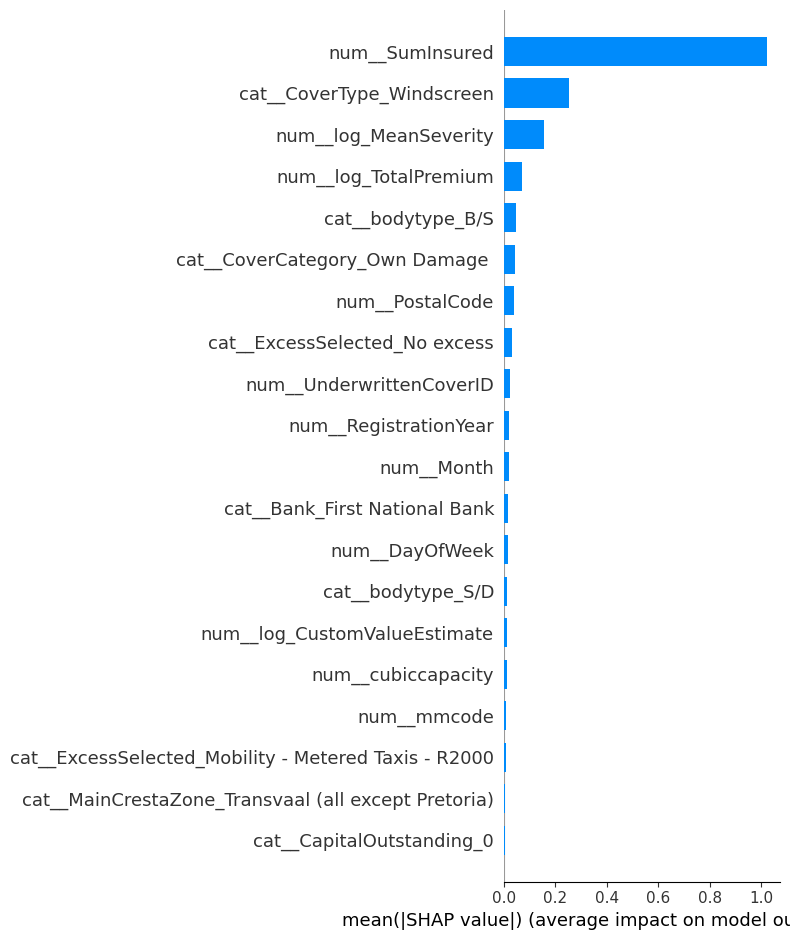

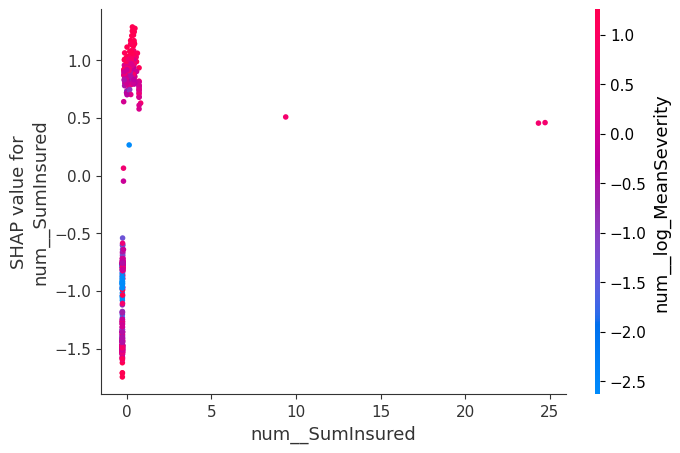

In [30]:
import shap
import pandas as pd
import numpy as np

# Ensure the best model (XGBoost Regressor) is available from Step 3.2
# and the processed test data (X_test_processed_sev) is available.

# 1. Map the processed features back to human-readable names
# This is necessary because the processed array X_test_processed_sev has generic column names
feature_map = {f'f{i}': name for i, name in enumerate(feature_names_sev)}

# Create an explainer for the XGBoost Regressor
# The XGBoost model is already trained as 'xgb_sev'
print("--- Calculating SHAP values for Claim Severity Model (XGBoost) ---")
explainer_sev = shap.TreeExplainer(xgb_sev)

# Calculate SHAP values for a subset of the test data (to speed up computation)
# Note: Using the sparse matrix output from preprocessor_sev
shap_values_sev = explainer_sev.shap_values(X_test_processed_sev[:2000])


# 2. Map SHAP values to feature names for plotting
# Create a DataFrame of the processed test data slice with mapped feature names
X_test_processed_df_sev = pd.DataFrame(
    X_test_processed_sev[:2000].todense() if hasattr(X_test_processed_sev, 'todense') else X_test_processed_sev[:2000],
    columns=feature_names_sev
)

# 3. Generate Summary Plot (Magnitude of Feature Impact)
print("Generating SHAP Summary Plot...")
# The summary plot shows which features are most important and their direction (positive/negative impact)

# We use the built-in SHAP plotting functions.
# Note: This will generate an inline plot in your notebook.

shap.summary_plot(
    shap_values_sev,
    X_test_processed_df_sev,
    plot_type="bar",
    show=False # Prevent immediate display to allow better formatting
)

# --- Top 5 Most Influential Features ---
# Get the mean absolute SHAP value for each feature
mean_abs_shap_sev = np.abs(shap_values_sev).mean(axis=0)
feature_importance_sev = pd.Series(mean_abs_shap_sev, index=feature_names_sev)
top_5_features_sev = feature_importance_sev.nlargest(5)

print("\n--- Top 5 Most Influential Features (Claim Severity) ---")
print(top_5_features_sev)

# Select the top feature for a detailed plot (e.g., dependence plot)
top_feature_name = top_5_features_sev.index[0]

print(f"\nGenerating SHAP Dependence Plot for Top Feature: {top_feature_name}")
# Plotting the raw SHAP values provides the clearest business interpretation.
# This plot shows how the feature's value impacts the claim size prediction.
shap.dependence_plot(
    top_feature_name,
    shap_values_sev,
    X_test_processed_df_sev,
    show=False # Prevent immediate display
)

In [32]:
# --- Select the best models and their preprocessors ---
best_severity_model = xgb_sev
best_frequency_model = xgb_freq
# These preprocessors were trained on DIFFERENT feature sets!
preprocessor_sev = preprocessor_sev
preprocessor_freq = preprocessor_freq

# Define the set of high-cardinality columns that were removed ONLY for the frequency model training
HIGH_CARDINALITY_COLS = ['PostalCode', 'make', 'Model']

# --- Define fixed business variables ---
EXPENSE_LOADING = 50.0 # R50 fixed administrative charge
PROFIT_MARGIN_PERCENT = 0.10 # 10% target profit margin on claims component

def calculate_risk_premium(policy_data: pd.DataFrame) -> pd.Series:
    """
    Calculates the new risk-based premium using the two-part modeling framework.
    This version correctly handles the feature sets required by both preprocessors.
    """
    # 1. Prepare data for Severity Prediction
    # preprocessor_sev was trained on the FULL feature set (including PostalCode, make, Model).
    # We must only drop the final targets/intermediates it wasn't trained on.
    # Policy data (df) already has these columns.
    X_sev_raw = policy_data.drop(
        columns=['TotalClaims', 'Claimed', 'ClaimSeverity', 'Margin', 'log_TotalClaims'], # Drop actual targets/intermediates
        errors='ignore'
    )
    
    # Ensure categorical columns are string-type before transforming
    for col in X_sev_raw.select_dtypes(include=['object', 'category']).columns:
        X_sev_raw[col] = X_sev_raw[col].astype(str)

    X_sev_processed = preprocessor_sev.transform(X_sev_raw)

    # 2. Predict Severity (S_pred)
    log_severity_pred = best_severity_model.predict(X_sev_processed)
    S_pred = np.expm1(log_severity_pred) # Dollar amount


    # 3. Prepare data for Frequency Prediction
    # preprocessor_freq was trained on the REDUCED feature set (without high-cardinality columns).
    X_freq_raw = policy_data.drop(
        columns=HIGH_CARDINALITY_COLS + ['TotalClaims', 'Claimed', 'ClaimSeverity', 'Margin', 'log_TotalClaims'],
        errors='ignore'
    )
    
    # Ensure categorical columns are string-type before transforming
    for col in X_freq_raw.select_dtypes(include=['object', 'category']).columns:
        X_freq_raw[col] = X_freq_raw[col].astype(str)
        
    X_freq_processed = preprocessor_freq.transform(X_freq_raw)

    # 4. Predict Frequency (P_claim)
    P_claim = best_frequency_model.predict_proba(X_freq_processed)[:, 1]


    # 5. Calculate the Pure Risk Premium (Expected Loss)
    Expected_Loss = P_claim * S_pred

    # 6. Apply Margin and Loading
    Gross_Risk_Premium = Expected_Loss * (1 + PROFIT_MARGIN_PERCENT) + EXPENSE_LOADING

    return pd.Series(Gross_Risk_Premium, index=policy_data.index)

# --- Example of Premium Calculation ---
# Use a small sample of the original data (df) to demonstrate the function
sample_policies = df.sample(5, random_state=42)
new_premiums = calculate_risk_premium(sample_policies)

print("\n--- Risk-Based Premium Optimization Framework Demo ---")
demo_df = pd.DataFrame({
    'Current Premium': sample_policies['TotalPremium'],
    'Predicted Risk Premium': new_premiums.round(2)
})
print(demo_df)


--- Risk-Based Premium Optimization Framework Demo ---
        Current Premium  Predicted Risk Premium
57024          7.082018               50.250000
343371         5.800965               50.139999
641034         4.895351               50.240002
42687          3.218421               50.049999
850800         4.672982               50.130001
